It is to note that GD, SGD and ALS are all used to optimize the same loss function in matrix factorization, quadratic loss function, given as: 
$$\text{Minimize } J = \frac{1}{2} ||R-UV^T||^2  $$
Although the optimization problem looks fairly similar to linear regression, both `U` and `V` are variables in matrix factorization while only `beta` needs to be optimized in linear regression. In both cases, one needs to take derivatives of the quadratic loss function and set to zero to find the optimum variable. However, the quadratic loss function of matrix factorization does not have an close-formed solution, thus needing optimization techniques like GD, SGD and ALS for convergence. <br>
GD: <br>
Gradient descent takes the partial derivative with respect to `U` and `V`. The partial derivatives are used to update the factor matrices as a gradient with learning rate/ step size `alpha` until convergence. In each iteration, all observed entries in `R` are used to calculate the gradient. Thus, all variables (m*k + n*k) are updated simultaneously. <br>
SGD: <br>
Stochastic gradient descent takes only one observation (one user-item pair) from the rating matrix to update the variables in each cycle. Similar to GD, it takes partial derivate of the quadratic loss function but only with respect to a selected user and item (U_i and V_j). Theoretically, this approach can also reach convergence. SGD can achieve convergence faster than GD hence it is less costly. However, it is noisier than GD since only one entry, instead of all, is considered in each update. Hence, SGD is preferable in large datasets to sacrifice smoothness for better efficiency, as computational time is the bottleneck in large-scale optimization. <br>
ALS: <br>
ALS alternatively assume `U` or `V` matrix as fixed features and the other matrix as variables. In this case, the objective function can be considered as m/n linear regressions and can be solved by least-square estimation. Since the least-square problem of each user/item is independent, the solution can be neatly obtained by matrix multiplication . Compare to GD and SGD, ALS are not as sensitive to initialization. Another advantage is that ALS does not require learning rate, while the convergence of GD and SGD are highly sensitive to the tuning of learning rate. However, ALS is not as efficient as SGD as all `U` (m*k) and `V` (n*k) variables and all entries (m*n) are used in each iteration. <br>

Given a large and sparse rating matrix, it is costly to compute the entire matrix. One should ignore the missing values during optimization to increase the efficiency. In the programme below however, since the datasets are relatively small, it is more time-consuming to select and disregard missing values hence such method was not applied. <br>
Alternatively, missing values can be imputed by row-wise mean (i.e. mean of user's ratings). Different users may have different tendencies in giving ratings, some with stricter and some with more lenient ratings. Although such imputation is unlikely the reality, it can capture the users' rating inclinations. Recommendataions are given to each user instead of each item. Hence, row-wise means can provide a better recommendation for each user. <br>
Row-wise mean imputation was implemented below but it produced a worse performance than setting them arbitarily as -1. Possible reason may be due to the small data size where some rows have no input at all. Hence, the optimization below continue to impute missing values as -1. <br>
Reference: the textbook, Recommender Systems <br>

In [ ]:
import numpy as np
import pandas as pd 
from numpy.linalg import lstsq
from sklearn.impute import SimpleImputer
class MatrixFactor:
    def __init__(self, k, opt_method = 'SGD', learn_rt = 0.005, num_iter=1000, print_enabled=True):
        
        self.opt_method = opt_method
        self.learn_rt = learn_rt
        self.num_iter = num_iter 
        self.k = k
        self.print_enabled = print_enabled
    def _Squared_Frobenius_Loss(self):
        """
        return
        1. n*m np.ndarray: the difference between A and estimated value at each entry of A; 
        2. total loss, the sum of errors for all entries of A. 
        """
        A_est = np.matmul(self.U, self.VT)
        diff_error = np.subtract(self.A, A_est)
        diff_error[self.nan_cell_mask] = 0
        sq_error = np.square(diff_error) 
        sq_error_sum = 0.5 * sq_error.sum() # the ignore missing data

        return diff_error, sq_error_sum 

    def _SGD(self): 
        """_SGD, should 
        1. update self.U, self.VT and 
        2. return a 1D np.ndarray which stores the loss after each iteration, 
        the length of the list should be the number of iteration + 1, 
        because we include the loss before optimization, i.e. the loss when 
        num_iter = 0  
          """
        # return Loss_list 
        pass
    def _GD(self):
        """
        Functionality is same as the _SGD method. 
        """
        pass 
    def _ALS(self):
        """
        Functionality is same as the _SGD method. 
        """
        pass
    def fit(self, A, init_U = None, init_VT = None):
        ## initialize U, V 
        self.A = A.copy()
        self.nan_cell_mask = np.where(np.isnan(self.A))
        self.A[self.nan_cell_mask] = -1  # empty entries are filled with arbitrary numbers for matrix calculation. 
        if init_U is None: 
            self.U = np.random.rand(np.size(self.A, 0), self.k)
        else:
            self.U = init_U
        if init_VT is None:
            self.VT = np.random.rand(self.k, np.size(self.A, 1))
        else:
            self.VT = init_VT

        """for optimization"""
        if self.opt_method == "SGD":
            loss_list = self._SGD()
        elif self.opt_method == "GD":
            loss_list = self._GD()
        elif self.opt_method == 'ALS':
            loss_list = self._ALS()
        else: 
            raise NotImplementedError("Cannot use provided optimization method!!!")
        return self.U, self.VT, loss_list 



In [ ]:
def _GD(self):
    loss_list = np.array([])
    for n in range(self.num_iter):
        # calcualte the squared Frobenius norm 
        diff, tol_error = self._Squared_Frobenius_Loss()
        # calculate the gradient for each entry of U
        grad_U = -np.matmul(diff, self.VT.T) 
        # calculate the gradient for each entry of VT
        grad_VT = -np.matmul(self.U.T, diff) 
        
        # update U and VT 
        self.U =  np.subtract(self.U, self.learn_rt*grad_U) 
        self.VT = np.subtract(self.VT, self.learn_rt*grad_VT) 
        # print total loss if needed 
        if self.print_enabled:
            print("iteration " + str(n) + ": " + str(tol_error))
        loss_list = np.append(loss_list, tol_error)
    return loss_list
MatrixFactor._GD = _GD
    

In [ ]:
import random
def _SGD(self):
    loss_list = np.array([])
    for n in range(self.num_iter):
        # calcualte the squared Frobenius norm 
        diff, tol_error = self._Squared_Frobenius_Loss()
        # randomly select an item to calculate gradient
        j = random.choice(range(self.A.shape[1]))
        # calculate the gradient for each entry of U
        grad_U = -np.outer(diff[:,j], self.VT[:,j]) 
        # randomly select an user to calculate gradient
        i = random.choice(range(self.A.shape[0]))
        # calculate the gradient for each entry of VT
        grad_VT = -np.outer(self.U[i,:].T, diff[i,:]) 
        
        # update U and VT 
        self.U =  np.subtract(self.U, self.learn_rt*grad_U) 
        self.VT = np.subtract(self.VT, self.learn_rt*grad_VT) 
       # print total loss if needed 
        if self.print_enabled:
            print("iteration " + str(n) + ": " + str(tol_error))
        loss_list = np.append(loss_list, tol_error)
    return loss_list
MatrixFactor._SGD = _SGD


In [ ]:
from sklearn.linear_model import LinearRegression
def _ALS(self):
    loss_list = np.array([])
    for n in range(self.num_iter):
        # calcualte the squared Frobenius norm 
        diff, tol_error = self._Squared_Frobenius_Loss()
        # keep U fixed and solve for VT
        self.VT = lstsq(self.U, self.A, rcond = -1)[0]
        # keep V fixed and solve for U
        self.U = np.transpose(lstsq(np.transpose(self.VT), np.transpose(self.A), rcond = -1)[0])
        # print total loss if needed 
        if self.print_enabled:
            print("iteration " + str(n) + ": " + str(tol_error))
        loss_list = np.append(loss_list, tol_error)
    return loss_list

MatrixFactor._ALS = _ALS

## Part 3 Experiment and Visualization

### 1. toy example

In [ ]:
from time import process_time

In [ ]:
d = {'item0': [np.nan, 7, 6, 1, 1,5], 
     'item1': [3, 6, 7, 2, np.nan, 4], 
      'item2': [3, 7, np.nan, 2, 1,5], 
     'item3': [1, 4, 4, 3, 2, 3],
      'item4': [1, 5, 3, 3, 3, 4], 
     'item5': [np.nan, 4, 4, 4, 3, 2]}
df = pd.DataFrame(data=d).astype('float32')
X = np.array(df)
# Set the parameters for each optimization method
learn_rt = 0.005
num_iter=300
MF_GD = MatrixFactor(k = 2, opt_method = 'GD', learn_rt = learn_rt, num_iter=num_iter, print_enabled=False)
MF_SGD = MatrixFactor(k = 2, opt_method = 'SGD', learn_rt = learn_rt, num_iter=num_iter, print_enabled=False)
MF_ALS = MatrixFactor(k = 2, opt_method = 'ALS', num_iter=num_iter, print_enabled=False)
# Training the model and record training time
start_GD = process_time()
U_GD, VT_GD, loss_hist_GD = MF_GD.fit(X)
time_GD = process_time() - start_GD

start_SGD = process_time()
U_SGD, VT_SGD, loss_hist_SGD = MF_SGD.fit(X)
time_SGD = process_time() - start_SGD

start_ALS = process_time()
U_ALS, VT_ALS, loss_hist_ALS = MF_ALS.fit(X)
time_ALS = process_time() - start_ALS

In [ ]:
print(U_GD, "\nuser-feature matrix using GD")
print(np.transpose(VT_GD), "\nitem-feature matrix using GD")

[[ 1.35181193  0.04003514]
 [ 2.47289563  1.6105621 ]
 [ 2.50488672  1.2793292 ]
 [ 0.08456117  1.90183016]
 [-0.0405926   1.54488638]
 [ 1.79546093  1.03675662]] 
user-feature matrix using GD
[[2.31373661 0.56827838]
 [2.04481054 0.87198525]
 [2.26903578 0.85743656]
 [0.77242539 1.44992137]
 [0.70804766 1.759488  ]
 [0.34394303 2.0083008 ]] 
item-feature matrix using GD


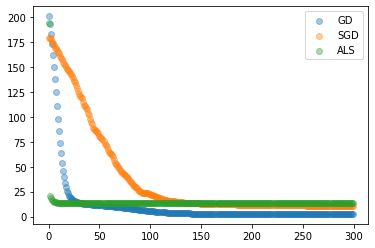

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.scatter(range(len(loss_hist_GD)), loss_hist_GD, label='GD', alpha = 0.4 )
plt.scatter(range(len(loss_hist_SGD)), loss_hist_SGD, label='SGD' , alpha = 0.4 )
plt.scatter(range(len(loss_hist_ALS)), loss_hist_ALS, label='ALS', alpha = 0.4  )
plt.legend()

In [ ]:
print("GD")
print("Loss: %.4f" % loss_hist_GD[-1])
print("Training time: %.6f" % time_GD)
print("\nSGD")
print("Loss: %.4f" % loss_hist_SGD[-1])
print("Training time: %.6f" % time_SGD)
print("\nALS")
print("Loss: %.4f" % loss_hist_ALS[-1])
print("Training time: %.6f" % time_ALS)

GD
Loss: 2.6206
Training time: 0.009013

SGD
Loss: 10.3500
Training time: 0.012912

ALS
Loss: 13.8691
Training time: 0.026206


### Example 2: MovieLens
 https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset?select=ratings.csv




In [ ]:
dataset = pd.read_csv('ratings.csv')
dataset.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
A = dataset.pivot(index="userId", columns='movieId', values='rating')

In [ ]:
A_small = np.array(A)[:100, :80]

In [ ]:
A_small

array([[4. , nan, 4. , ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [4.5, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, 3.5, ..., nan, nan, nan]])

In [ ]:
# Set the parameters for each optimization method
learn_rt = 0.01
num_iter = 600
MF_GD = MatrixFactor(k = 24, opt_method = 'GD', learn_rt = learn_rt, num_iter=num_iter, print_enabled=False)
MF_SGD = MatrixFactor(k = 24, opt_method = 'SGD', learn_rt = learn_rt, num_iter=num_iter, print_enabled=False)
MF_ALS = MatrixFactor(k = 24, opt_method = 'ALS', num_iter=num_iter, print_enabled=False)
# Training the model and record training time
start_GD = process_time()
U_GD, VT_GD, loss_hist_GD = MF_GD.fit(A_small)
time_GD = process_time() - start_GD

start_SGD = process_time()
U_SGD, VT_SGD, loss_hist_SGD = MF_SGD.fit(A_small)
time_SGD = process_time() - start_SGD

start_ALS = process_time()
U_ALS, VT_ALS, loss_hist_ALS = MF_ALS.fit(A_small)
time_ALS = process_time() - start_ALS

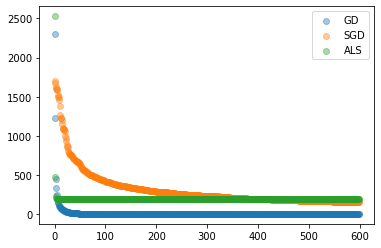

In [ ]:
plt.scatter(range(len(loss_hist_GD)), loss_hist_GD, label='GD', alpha = 0.4 )
plt.scatter(range(len(loss_hist_SGD)), loss_hist_SGD, label='SGD' , alpha = 0.4 )
plt.scatter(range(len(loss_hist_ALS)), loss_hist_ALS, label='ALS', alpha = 0.4  )
plt.legend()

In [ ]:
print("GD")
print("Loss: %.4f" % loss_hist_GD[-1])
print("Training time: %.6f" % time_GD)
print("\nSGD")
print("Loss: %.4f" % loss_hist_SGD[-1])
print("Training time: %.6f" % time_SGD)
print("\nALS")
print("Loss: %.4f" % loss_hist_ALS[-1])
print("Training time: %.6f" % time_ALS)

GD
Loss: 0.0000
Training time: 0.099014

SGD
Loss: 151.4268
Training time: 0.093157

ALS
Loss: 185.7841
Training time: 0.946382


In [ ]:
pred_GD = np.matmul(U_GD, VT_GD)
user5_GD = pred_GD[5,:]
top10_GD = sorted(range(len(user5_GD)), key=lambda i: user5_GD[i], reverse=True)[:10]

pred_SGD = np.matmul(U_SGD, VT_SGD)
user5_SGD = pred_SGD[5,:]
top10_SGD = sorted(range(len(user5_SGD)), key=lambda i: user5_SGD[i], reverse=True)[:10]

pred_ALS = np.matmul(U_ALS, VT_ALS)
user5_ALS = pred_ALS[5,:]
top10_ALS = sorted(range(len(user5_ALS)), key=lambda i: user5_ALS[i], reverse=True)[:10]

print("Top 10 recommendations to user 5")
print("By GD")
print(top10_GD)
print("\nBy SGD")
print(top10_SGD)
print("\nBy ALS")
print(top10_ALS)

Top 10 recommendations to user 5
By GD
[45, 8, 72, 56, 48, 50, 33, 77, 21, 4]

By SGD
[65, 72, 45, 27, 66, 38, 56, 67, 19, 34]

By ALS
[77, 2, 33, 21, 4, 37, 6, 53, 5, 16]


In both examples, it is seen that the curves of SGD are less smooth than the other two, demonstrating that SGD is noiser than GD and ALS as it only uses one observation in each update. It also reaches convergence the slowest. However, both GD and ALS require more time than SGD for the same number of interations, and such effect will be more significant when the dataset is even larger. <br>
In terms of accuracy, GD is the most accurate among the three. It is observed that although ALS reaches convergence very quickly, the loss is kept at a certain level whereas the losses in GD and SGD can be improved by increasing learning rate or the number of iterations. <br>
It is interesting to observe that the recommendations the three methods are fairly different. It shows that although the matrix factorization is optimized in all three methods, their variables can be very different and provide different sets of recommendation.